<a href="https://colab.research.google.com/github/jsteng19/plane_classification/blob/main/plane_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

global dependencies:

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pathlib, os


print(tf.__version__)

2.4.1


## Import the Dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path_str = "/content/drive/MyDrive/Lubin Lab/Plane Catagorization Project/Civil Aircraft"
data_dir = pathlib.Path(base_path_str)


display total image count and file types of all images:

In [4]:
image_paths = data_dir.glob('**/*.*')
file_types = [img.suffix for img in image_paths]
file_types = {ftype: file_types.count(ftype) for ftype in set(file_types)}
print(file_types)
print("total images: " + str(sum(file_types.values())))

{'.jpg': 300}
total images: 300


converts all image types to .jpg (results persistent in Google Drive between Colab sessions):

In [99]:
image_paths = data_dir.glob('**/*.*')
for img_path in image_paths:
  ftype = img_path.suffix
  if ftype != ".jpg":
    img = Image.open(img_path)
    img = img.convert('RGB')
    img.save(img_path.with_suffix('.jpg'))
    img_path.unlink()


compute average aspect ratio:

In [14]:
image_paths = data_dir.glob('**/*.*')
images = [Image.open(img_path) for img_path in image_paths]
widths, heights = zip(*[(img.width, img.height) for img in images])
avg_width, avg_height = sum(widths) / len(widths), sum(heights) / len(heights)
print("avg_width: " + str(avg_width))
print("avg_height: " + str(avg_height))

aspect_ratio = avg_height / avg_width
print(aspect_ratio)

avg_width: 1001.54
avg_height: 621.39
0.6204345308225333


Divides the images into training, validation, testing  (results persistent in Google Drive between Colab sessions):

In [12]:
from math import ceil
from random import shuffle

datasets = {'train', 'val', 'test'}
portions = {'train': 0.8, 'val': 0.1, 'test': 0.1}
assert sum(portions.values()) == 1

for dset in datasets:
    (data_dir / dset).mkdir(exist_ok = True)

subdirs = os.listdir(base_path_str)
classes = set(subdirs) - datasets
print(classes)

for cls in classes:
  unseparated_images = list((data_dir / cls).glob('*.*'))
  num_images = len(unseparated_images)
  print("num images: {}".format(num_images))
  shuffle(unseparated_images)
  unseparated_images = iter(unseparated_images)

  for dset in datasets:
    (data_dir / dset / cls).mkdir(exist_ok = True)
    count = 0
    for img in unseparated_images:
      img.rename(data_dir / dset / cls / img.name)
      count += 1
      if count >= ceil(portions[dset] * num_images):
        break

{'Civil Helicopters', 'CRJ 900', 'Cessna CitationJet M2', 'Boeing 737-800', 'Cessna 172', 'Airbus A319'}
num images: 50
num images: 50
num images: 50
num images: 50
num images: 50
num images: 50


Creates training and validation sets as BatchDatasets:

In [5]:


batch_size = 20
# img_width = 256
# img_height = int(aspect_ratio * img_width)
# print("height: {}".format(img_height))
img_width = 150
img_height = 150


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  (data_dir / 'train'),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
train_ds = list(train_ds)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  (data_dir / 'val'),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = list(val_ds)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  (data_dir / 'test'),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = list(test_ds)



Found 240 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


In [34]:
print(test_ds[0][0].shape)

(20, 150, 150, 3)


## Explore the data


show the shape:

In [92]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 150, 150, 3)
(20,)


show effect of normalization:

> Indented block



In [74]:
for image_batch, labels_batch in train_ds: 
  print(np.min(image_batch[0]), np.max(image_batch[0]))
  image_batch = tf.keras.applications.vgg16.preprocess_input(image_batch)
  print(np.min(image_batch[0]), np.max(image_batch[0]))
  break


0.0 255.0
-123.68 151.061


display the first image of each batch with label:


tf.Tensor(4, shape=(), dtype=int32)
Cessna CitationJet M2
tf.Tensor(1, shape=(), dtype=int32)
Boeing 737-800
tf.Tensor(2, shape=(), dtype=int32)
CRJ 900
tf.Tensor(4, shape=(), dtype=int32)
Cessna CitationJet M2
tf.Tensor(4, shape=(), dtype=int32)
Cessna CitationJet M2
tf.Tensor(1, shape=(), dtype=int32)
Boeing 737-800
tf.Tensor(2, shape=(), dtype=int32)
CRJ 900
tf.Tensor(3, shape=(), dtype=int32)
Cessna 172


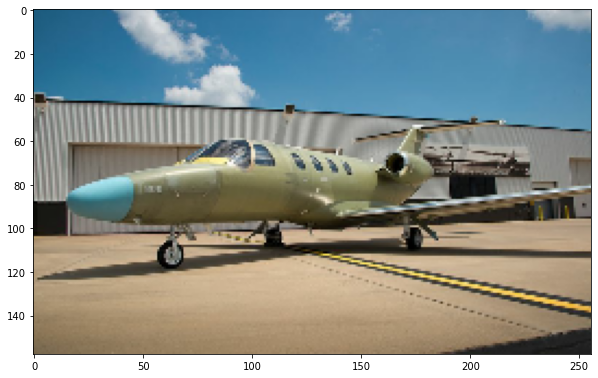

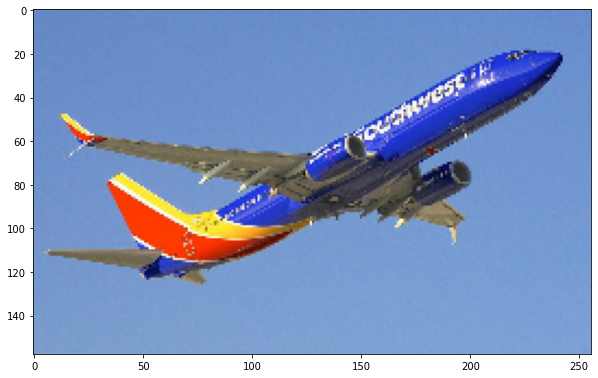

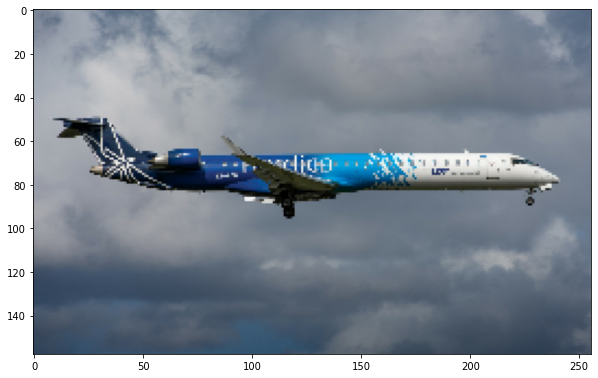

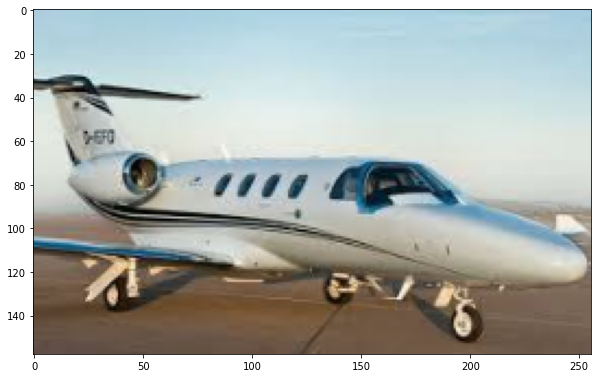

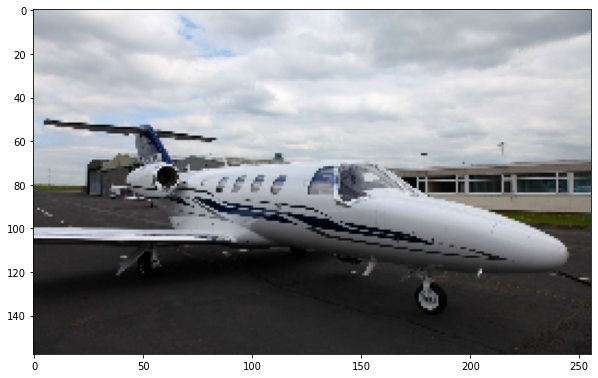

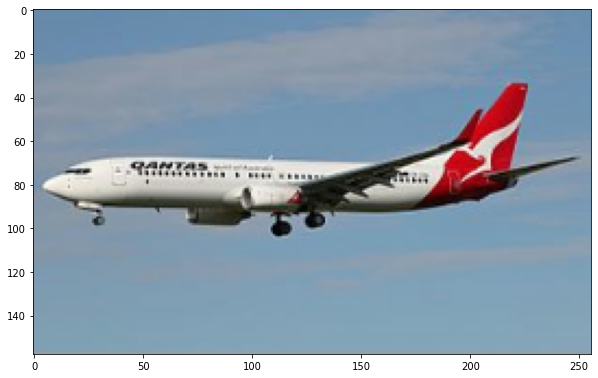

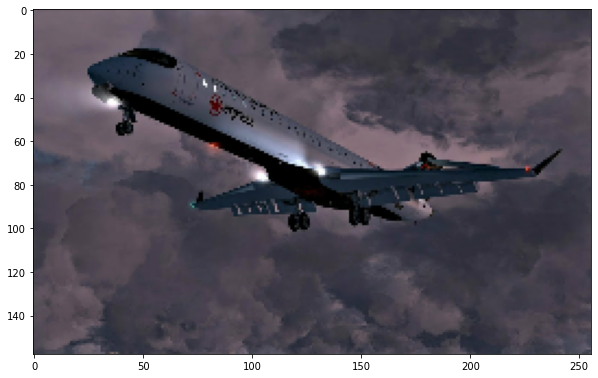

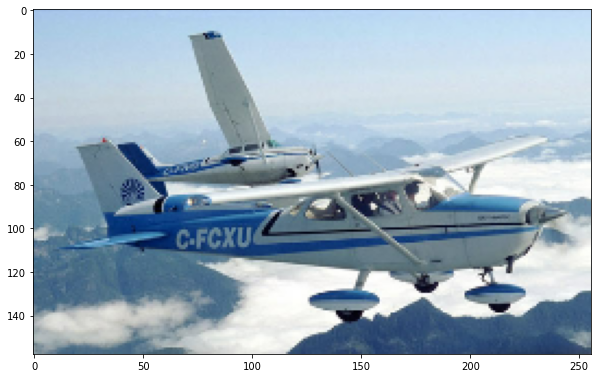

In [24]:

for image_batch, labels_batch in train_ds:
  plt.figure(figsize=(10, 10))
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  print(labels_batch[0])
  print(label_names[labels_batch[0].numpy().astype("uint8")])



## Build the model


import the pretrained convnet:

In [6]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(img_height, img_width, 3))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

extract features by running the convnet on the entire dataset:

In [7]:
def extract_features(ds):
  features = np.zeros(shape=(len(ds), 4, 4, 512))
  labels = np.zeros(shape=(len(ds)))
  
  for inputs_batch, labels_batch in ds:
    inputs_batch = tf.keras.applications.vgg16.preprocess_input(inputs_batch) #  centers pixel values at 0
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    
  return features, labels

train_features, train_labels = extract_features(train_ds)
validation_features, validation_labels = extract_features(val_ds)
test_features, test_labels = extract_features(test_ds)


In [12]:
print('train features: {}'.format(train_features.shape))
print('train labels: {}'.format(train_labels.shape))
print("val: {}".format(len(validation_features)))
print("test: {}".format(len(test_features)))

train features: (240, 4, 4, 512)
train labels: (240,)
val: 30
test: 30


build the densely connected net to be trained:

In [9]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = models.Sequential()
model.add(layers.Flatten(input_shape =(4, 4, 512)))
model.add(layers.Dense(256, activation='relu', ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names)))

model.summary()

model.compile(
  #optimizer=optimizers.RMSprop(lr=2e-5),
  optimizer = 'adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc']),

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 2,098,950
Trainable params: 2,098,950
Non-trainable params: 0
_________________________________________________________________


(None,)

## Train the model


In [10]:
history = model.fit(train_features, train_labels,
  epochs=10,
  batch_size=5,
  validation_data=(validation_features, validation_labels))


Epoch 1/10
48/48 [==============================] - 1s 18ms/step - loss: 46.7324 - acc: 0.2599 - val_loss: 21.5576 - val_acc: 0.5000
Epoch 2/10
48/48 [==============================] - 0s 10ms/step - loss: 14.0256 - acc: 0.6629 - val_loss: 9.7064 - val_acc: 0.6333
Epoch 3/10
48/48 [==============================] - 0s 10ms/step - loss: 6.0773 - acc: 0.7678 - val_loss: 8.7326 - val_acc: 0.5000
Epoch 4/10
48/48 [==============================] - 1s 10ms/step - loss: 1.7848 - acc: 0.8639 - val_loss: 5.6216 - val_acc: 0.6333
Epoch 5/10
48/48 [==============================] - 0s 10ms/step - loss: 2.0422 - acc: 0.8777 - val_loss: 7.6084 - val_acc: 0.6667
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 1.7076 - acc: 0.8882 - val_loss: 4.6691 - val_acc: 0.6000
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 1.1982 - acc: 0.9303 - val_loss: 7.3638 - val_acc: 0.5333
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.7090 

### Evaluate accuracy


In [11]:
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)


print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 1.5208 - acc: 0.9000

Test accuracy: 0.8999999761581421


### Make predictions


In [14]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [35]:
predictions = probability_model.predict(test_features)

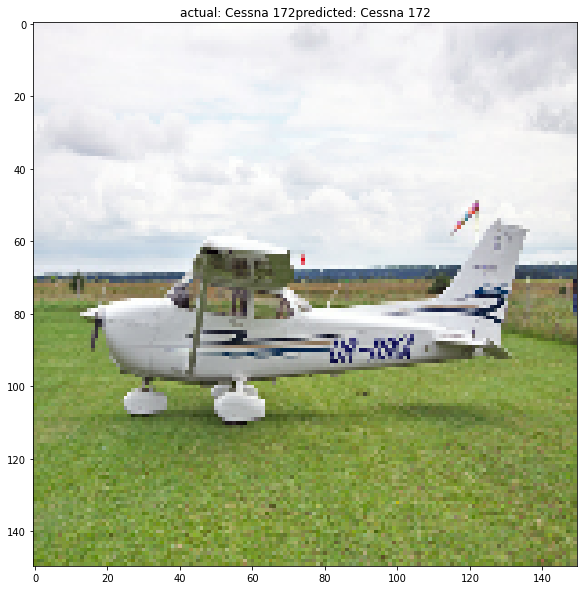

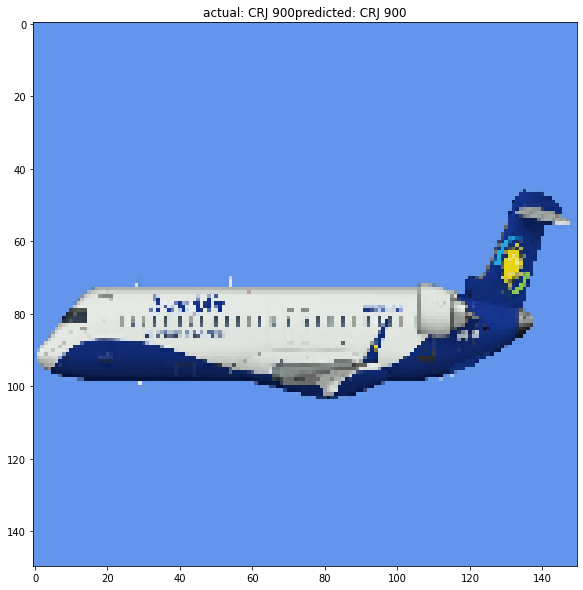

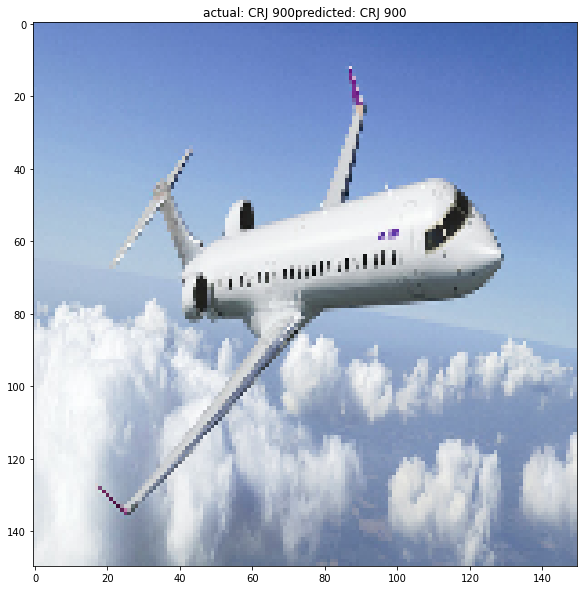

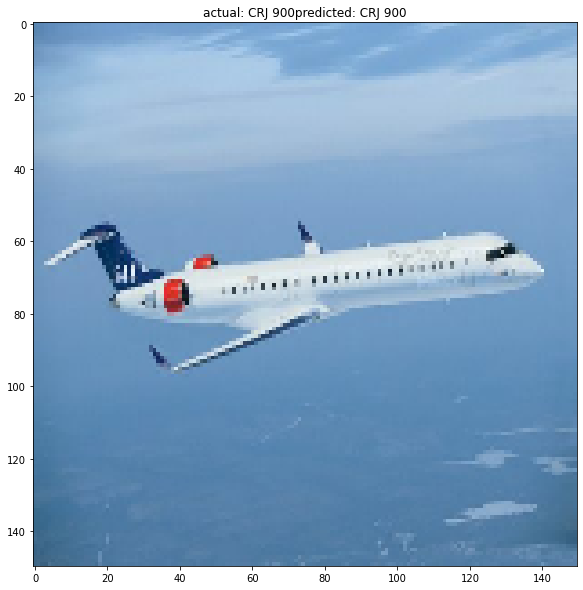

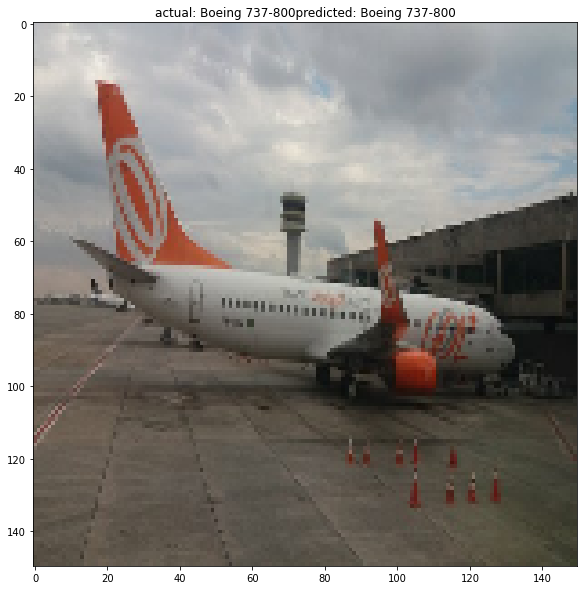

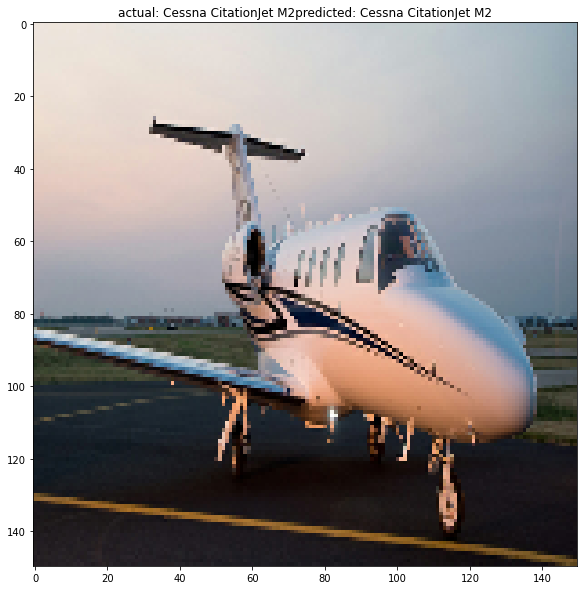

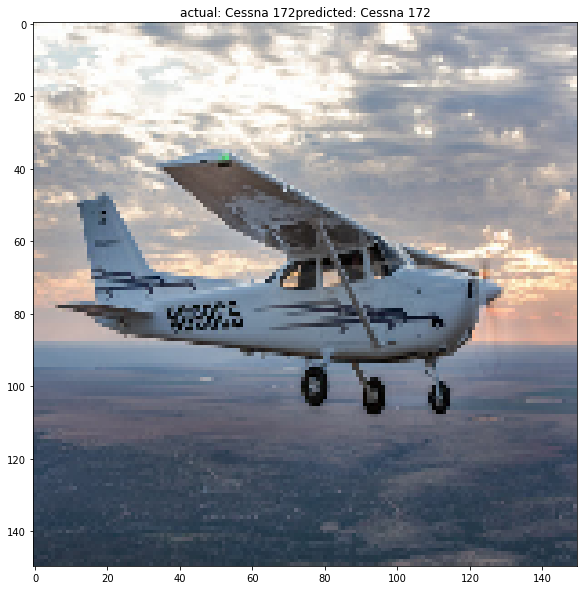

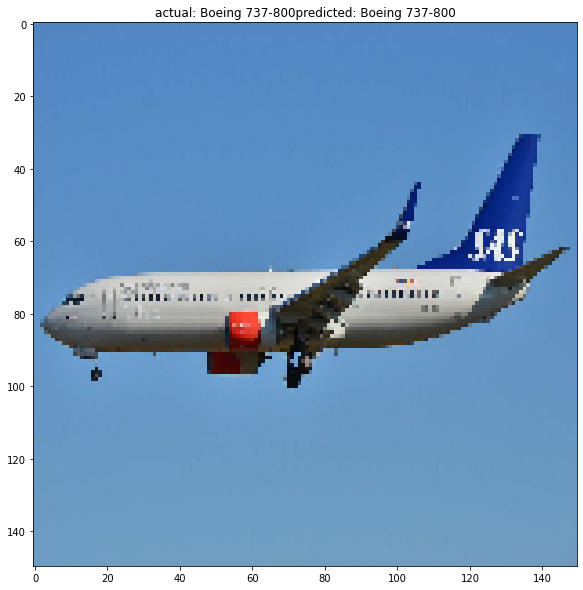

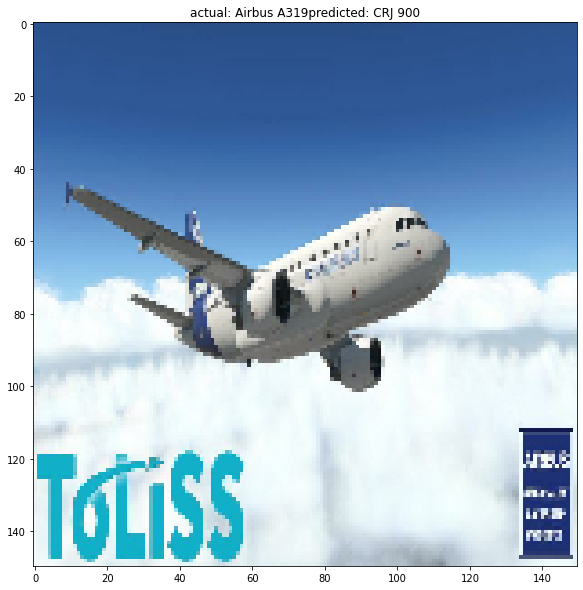

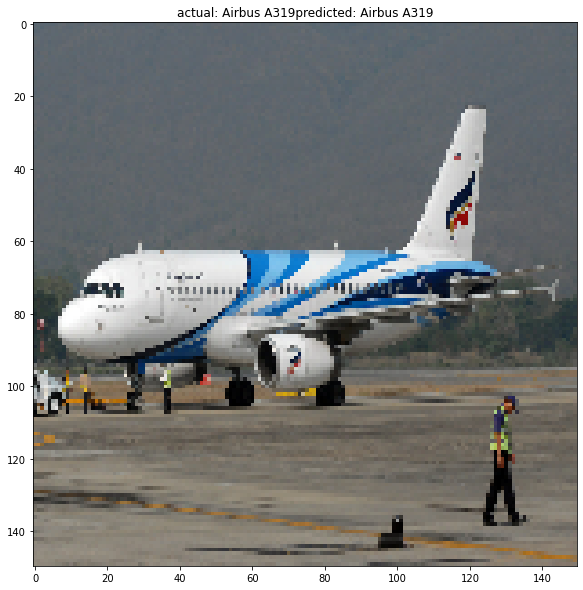

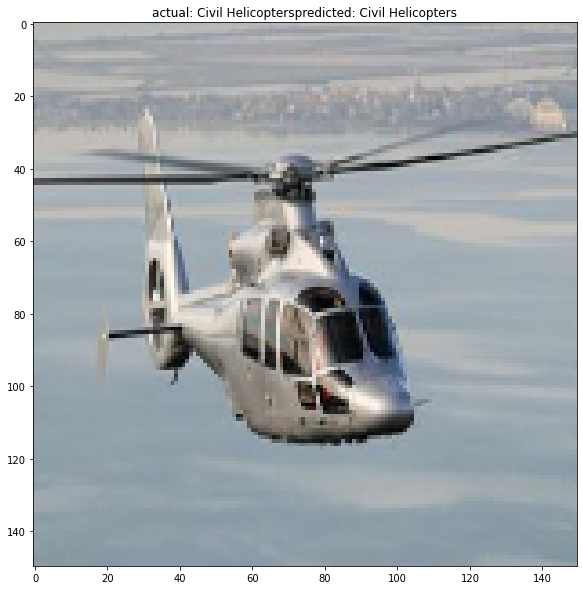

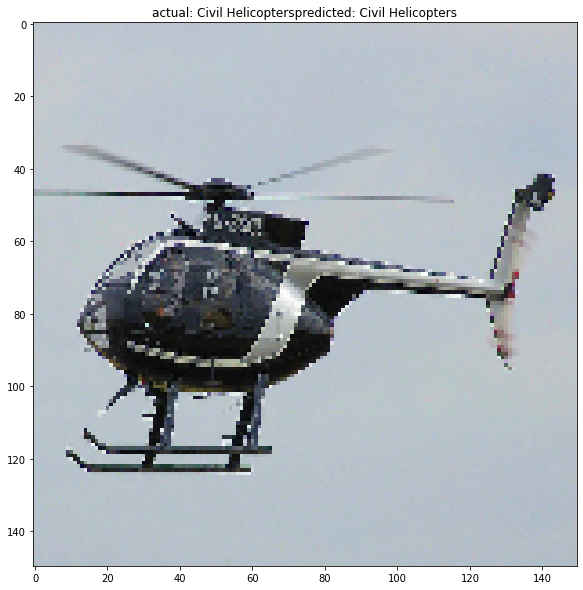

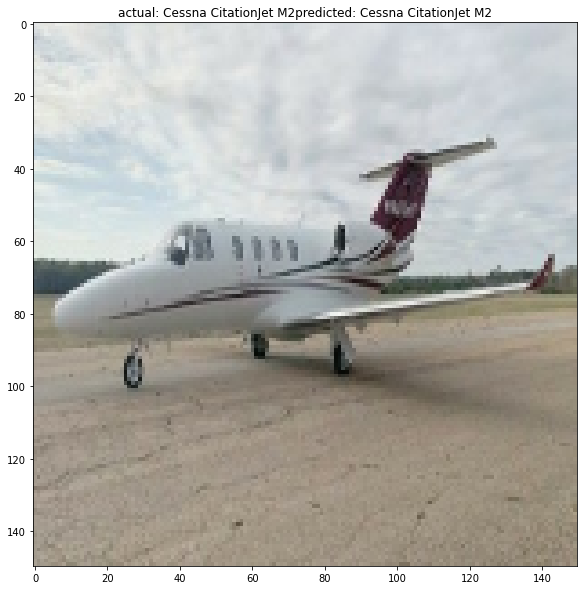

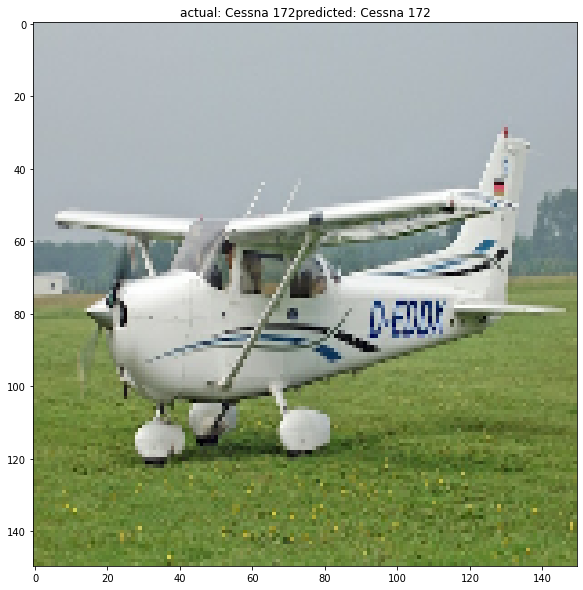

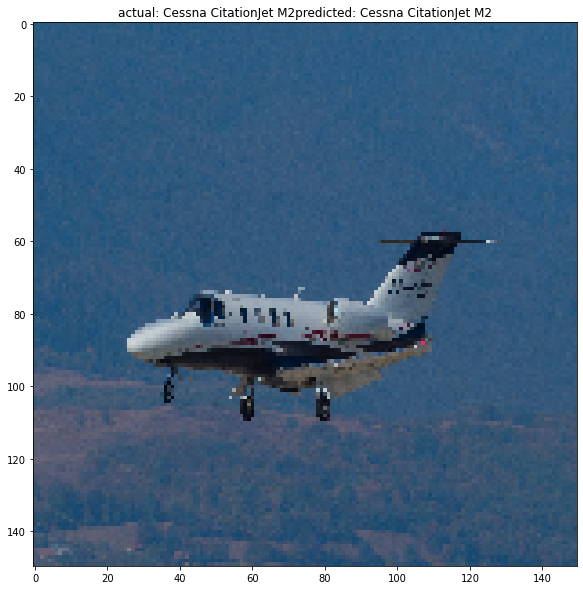

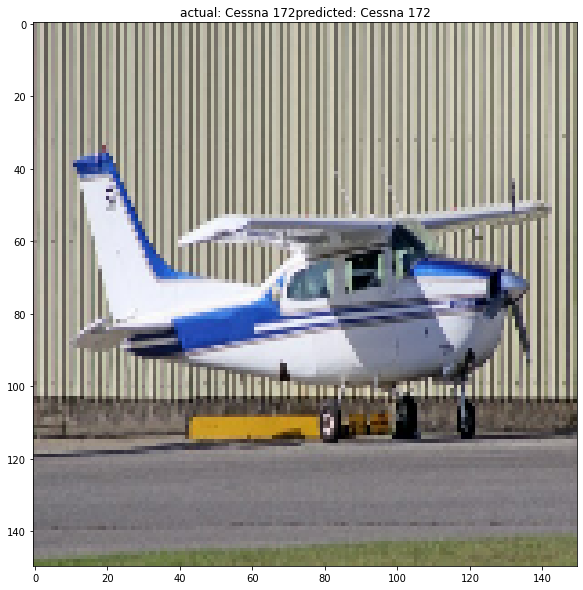

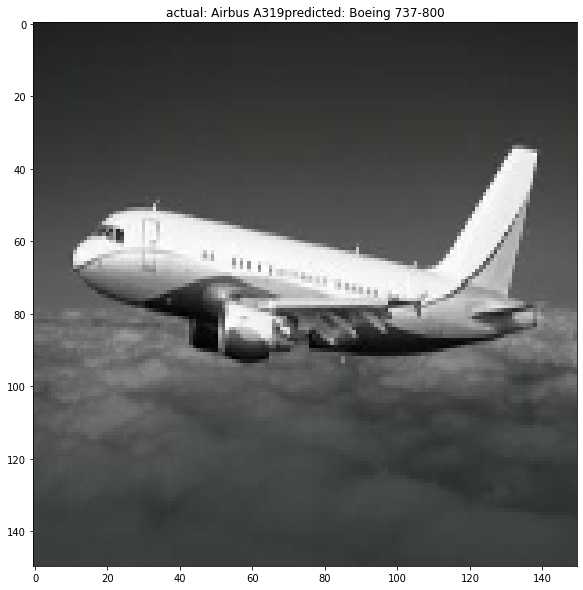

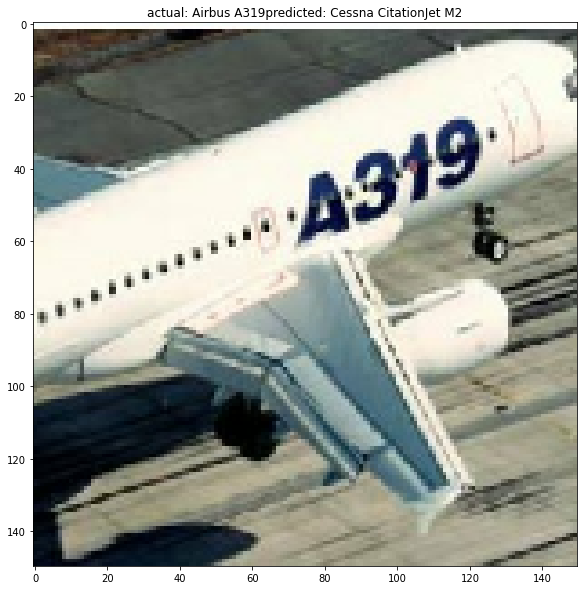

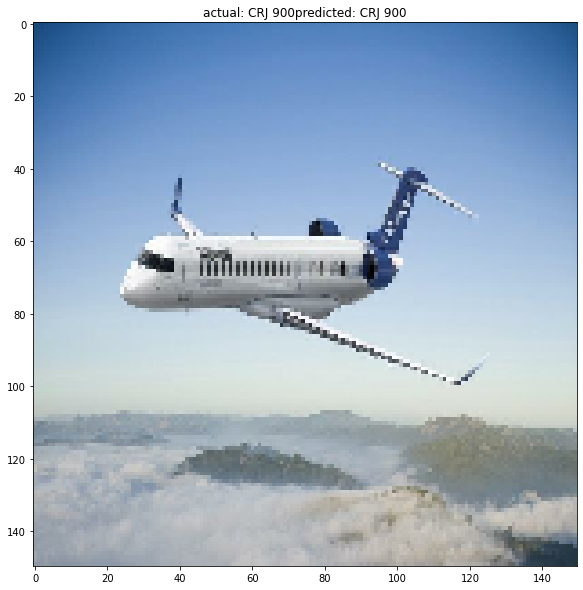

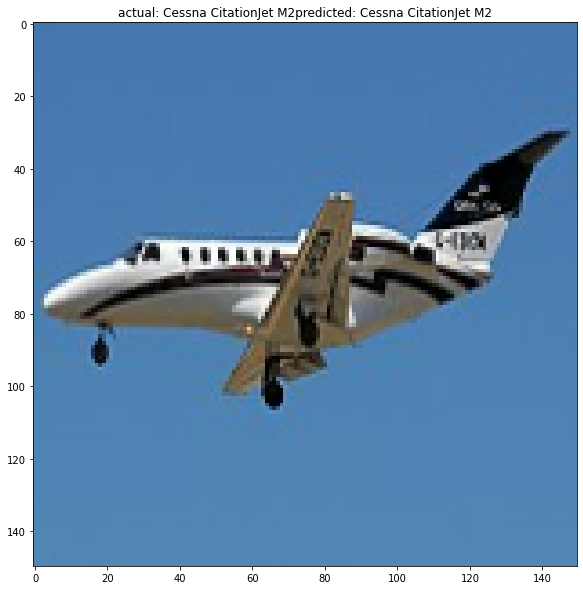

In [40]:
for n in range(20):
  actual = class_names[test_ds[0][1][n]]
  predicted = class_names[np.argmax(predictions[n])]
  plt.figure(figsize=(10, 10))
  plt.imshow(test_ds[0][0][n].numpy().astype("uint8"))  #  nth image in 0th batch
  plt.title("actual: " + actual + ", predicted: " + predicted)


In [24]:
test_labels[1]

2.0

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

Now predict the correct label for this image:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

And the model predicts a label as expected.